In [18]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from astropy.table import Table
%matplotlib inline

In [83]:
data_path = "/global/project/projectdirs/desi/users/forero/datachallenge2017/test_20170710/surveysim/output/"
plan_files = glob.glob(os.path.join(data_path, "plan_*"))
progress_files = glob.glob(os.path.join(data_path, "progress_*"))
progress_files = sorted(progress_files)
plan_files = sorted(plan_files)

a = Table.read(plan_files[-1])
b = Table.read(progres_files[-1])
print(a[:10])
print(b[:10])
print(b.keys())

tileid   ra    dec  pass group priority active   hourangle   
------ ------ ----- ---- ----- -------- ------ --------------
     4 335.03 19.88    0     2        6  False -8.62037277222
     6 333.22 14.84    0     2        6  False -10.1858892441
     7 332.35 12.32    0     2        6  False -8.91088867188
     8  319.9  6.05    0     2        6  False -18.1183185577
     9 330.67  7.31    0     2        6  False -9.06365966797
    10 329.84   4.8    0     2        9  False  1.03707814217
    11  326.4  1.37    0     2        9  False  6.51705217361
    12 326.88  4.31    0     2        9  False  18.2158660889
    13 324.73  5.92    0     2        6  False -14.3890371323
    14 322.58  7.47    0     2        6  False -12.4090747833
tileid pass   ra   ...      moonalt [32]          moonsep [32]    
             deg   ...          deg                   deg         
------ ---- ------ ... ---------------------- --------------------
     4    0 335.03 ...  -26.0160598755 .. 0.0  101.1171

In [84]:
n_progress = len(progress_files)
n_active = np.ones(n_plan)
n_0 = np.ones(n_plan)
n_2 = np.ones(n_plan)
for i in range(n_progress):
    a = Table.read(progress_files[i])
    n_0[i] = np.count_nonzero(a['status']==0)
    n_2[i] = np.count_nonzero(a['status']==2)
#    plt.scatter(a['ra'][a['status']==2], a['dec'][a['status']==2], alpha=0.1)

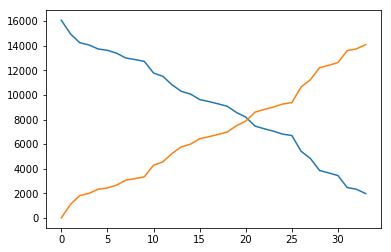

In [85]:
plt.plot(n_0)
plt.plot(n_2)